Loading data...
Number of samples: 1727999
Preprocessing data...
Applying rotational noise reduction...


Processing: 100%|██████████| 1727949/1727949 [1:38:38<00:00, 291.96window/s]



Total processing time: 5918.56 seconds


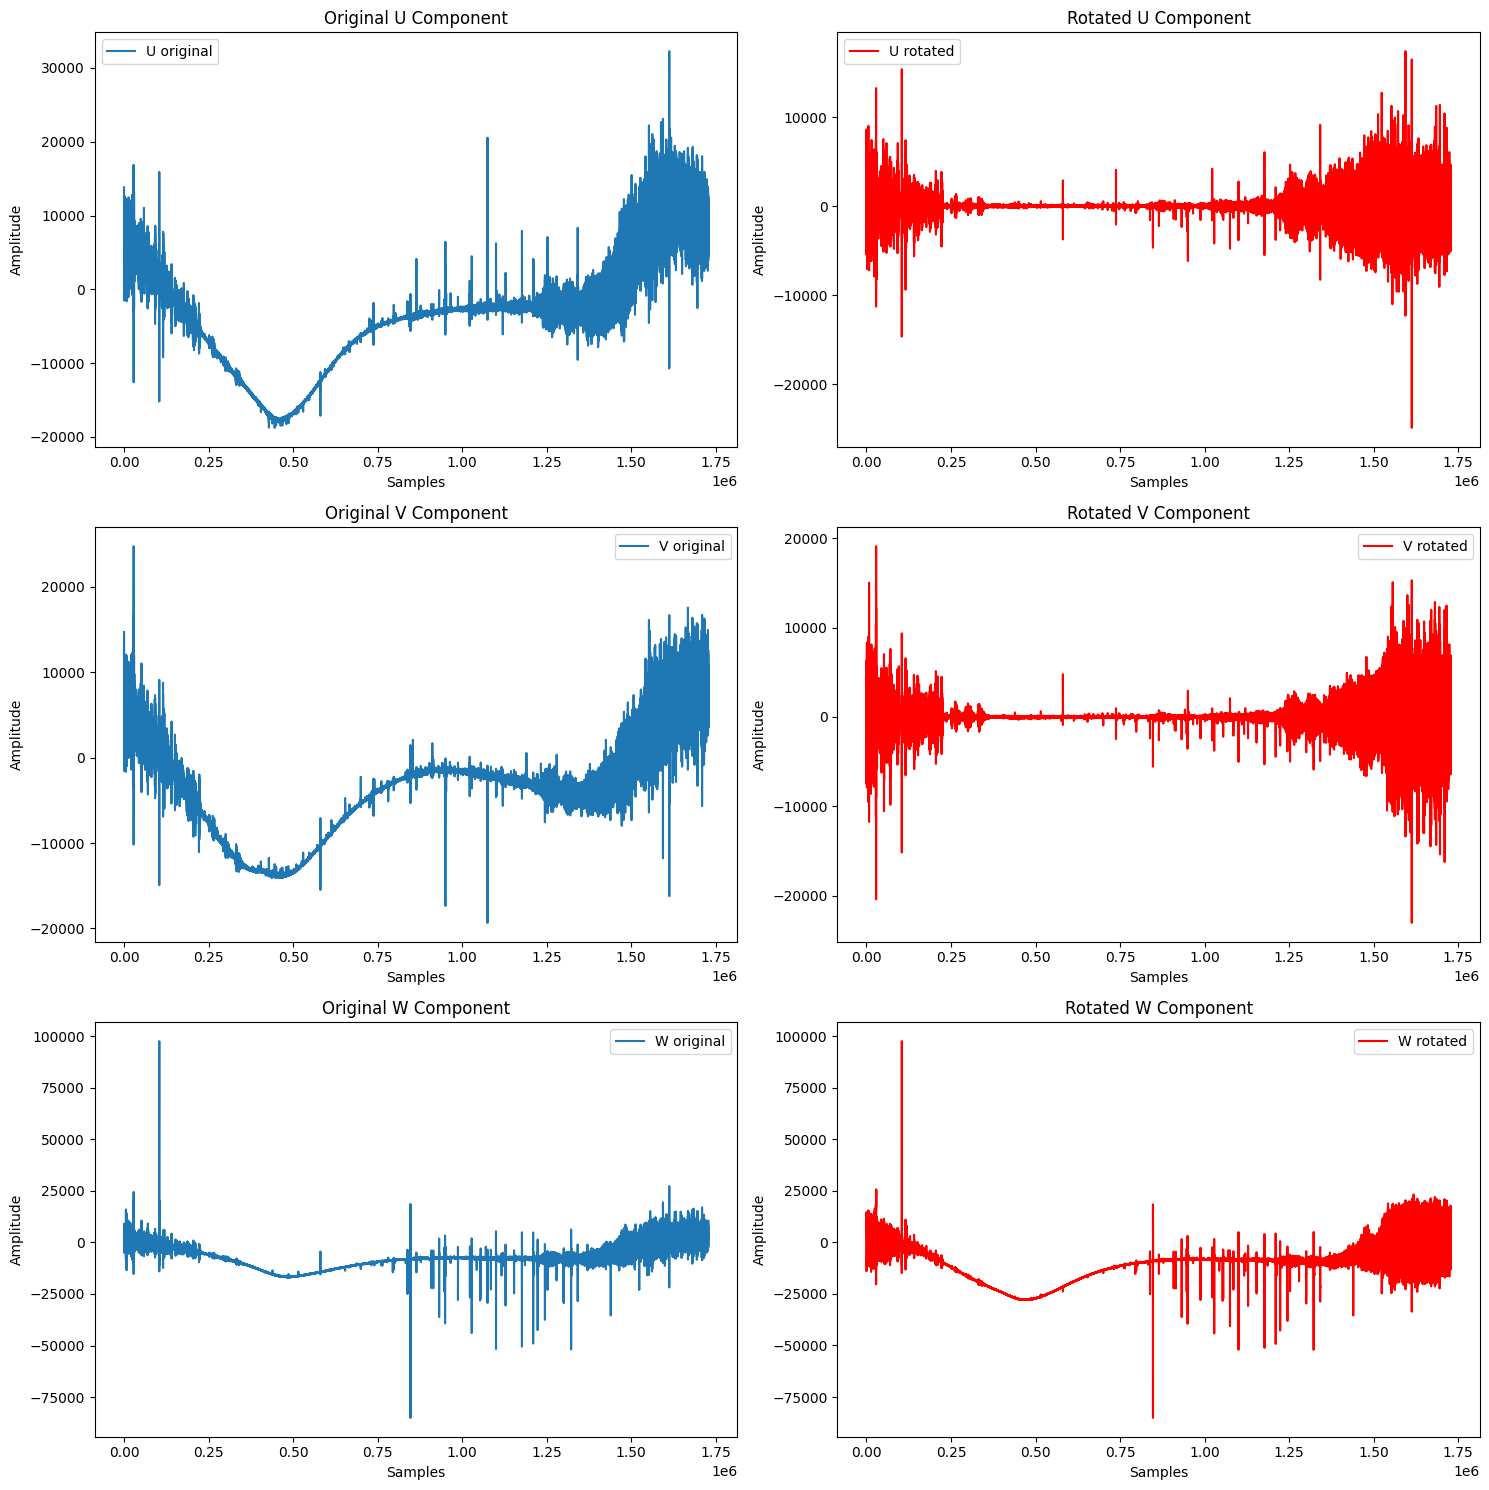

SNR U original: 33.77 dB
SNR U after rotation: 24.88 dB

SNR V original: 32.65 dB
SNR V after rotation: 24.21 dB

SNR W original: 43.34 dB
SNR W after rotation: 35.58 dB



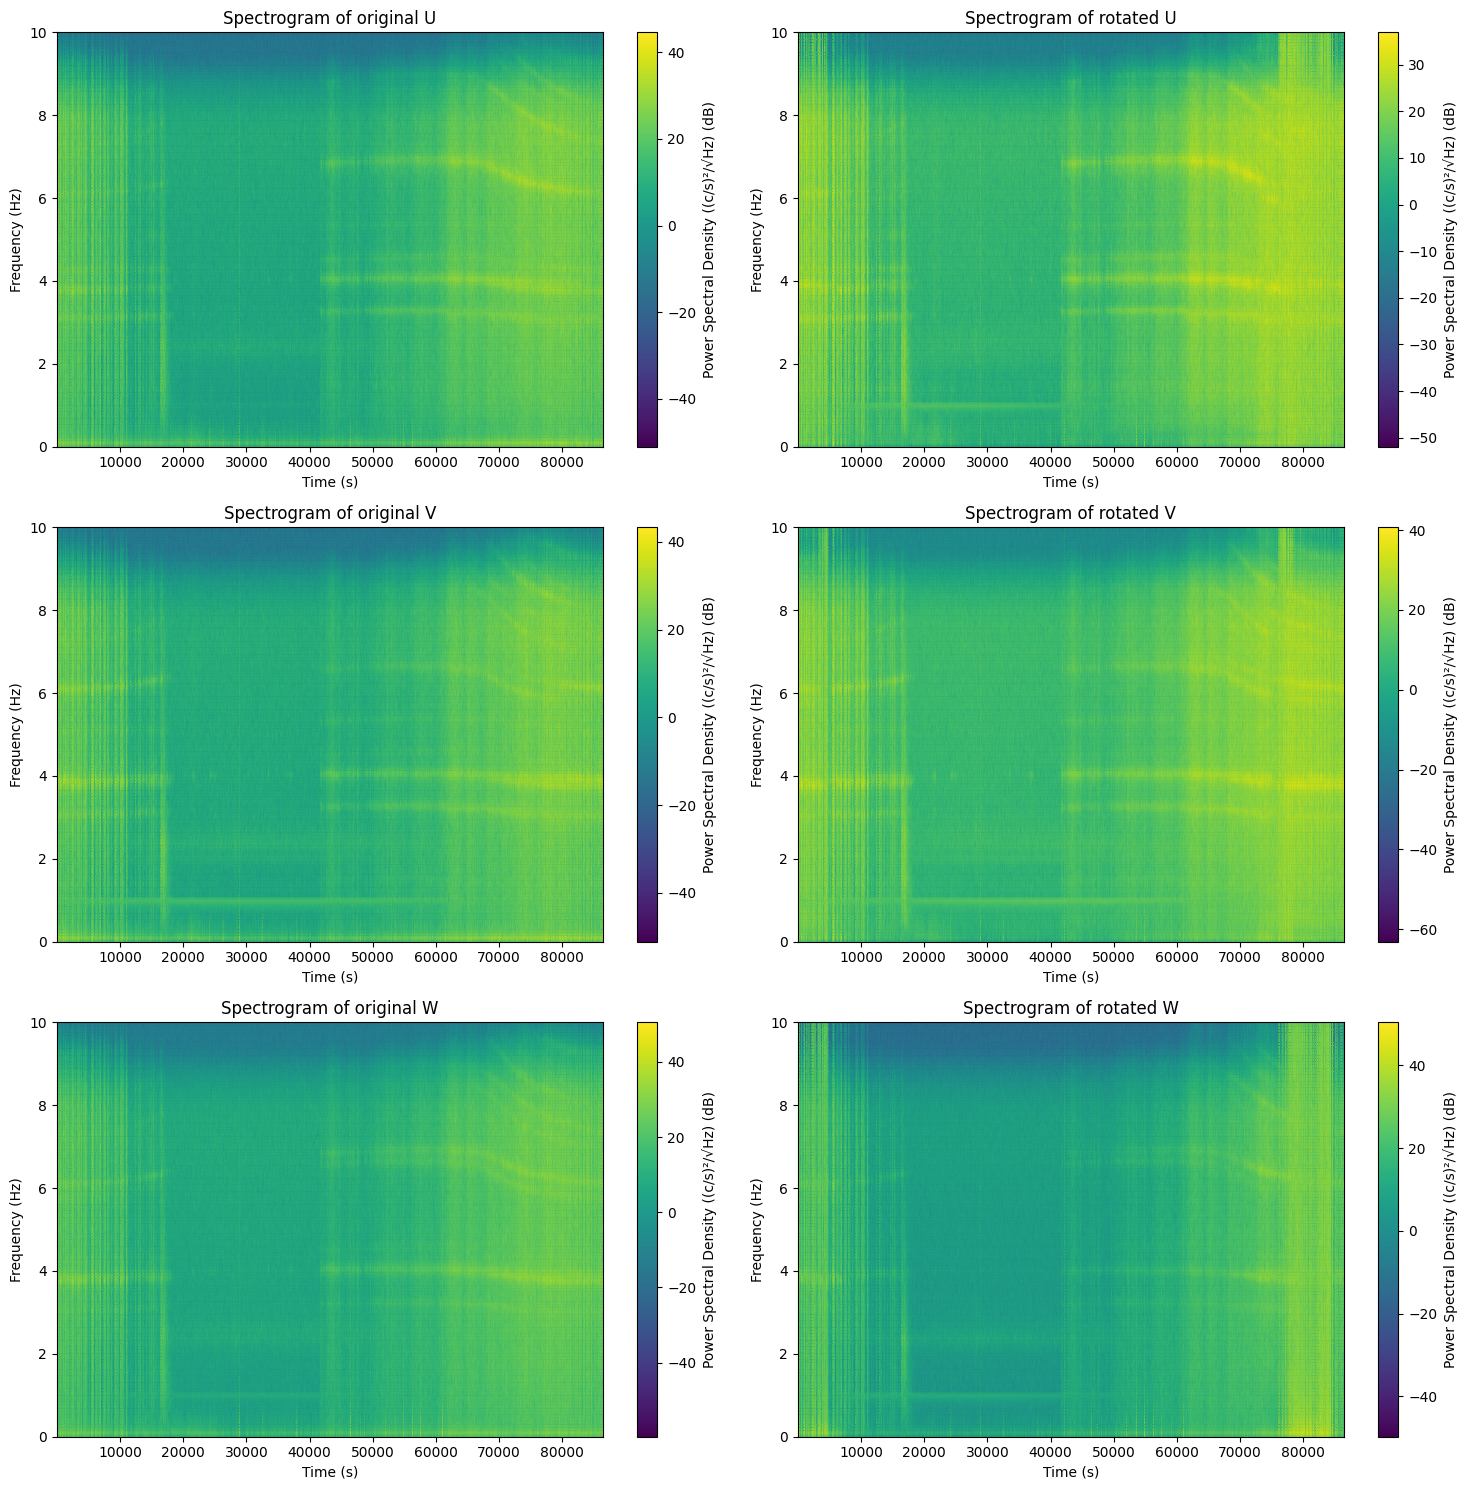

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from obspy import read
from scipy.optimize import minimize
from scipy import signal
from tqdm import tqdm
import time

def rotational_noise_reduction_3d(U, V, W, window_length=51):
    """
    Applies the rotational noise reduction method to 3-component data.

    Parameters:
    U, V, W (array): Seismogram components
    window_length (int): Length of the moving window

    Returns:
    tuple: Rotated U, V, W components
    """
    def rotation_matrix(angles):
        """Creates a 3D rotation matrix from three angles"""
        a, b, c = angles
        Rx = np.array([[1, 0, 0], [0, np.cos(a), -np.sin(a)], [0, np.sin(a), np.cos(a)]])
        Ry = np.array([[np.cos(b), 0, np.sin(b)], [0, 1, 0], [-np.sin(b), 0, np.cos(b)]])
        Rz = np.array([[np.cos(c), -np.sin(c), 0], [0, np.cos(c), 0], [0, 0, 1]])
        return np.dot(Rz, np.dot(Ry, Rx))

    def energy(angles, data):
        """Calculates the energy of the rotated signal"""
        R = rotation_matrix(angles)
        rotated = np.dot(data, R.T)
        return -np.sum(rotated[:, 2]**2)  # Maximize energy in Z component

    N = len(U)
    U_rot, V_rot, W_rot = np.zeros(N), np.zeros(N), np.zeros(N)

    start_time = time.time()
    for i in tqdm(range(N - window_length + 1), desc="Processing", unit="window"):
        window = np.array([U[i:i+window_length], V[i:i+window_length], W[i:i+window_length]]).T

        # Optimize rotation angles
        res = minimize(energy, [0, 0, 0], args=(window,), method='Powell')
        optimal_angles = res.x

        # Apply optimal rotation
        R = rotation_matrix(optimal_angles)
        rotated = np.dot(window, R.T)

        U_rot[i + window_length//2] = rotated[window_length//2, 0]
        V_rot[i + window_length//2] = rotated[window_length//2, 1]
        W_rot[i + window_length//2] = rotated[window_length//2, 2]

    # Fill the edges
    for arr in [U_rot, V_rot, W_rot]:
        arr[:window_length//2] = arr[window_length//2]
        arr[-(window_length//2):] = arr[-(window_length//2 + 1)]

    end_time = time.time()
    print(f"\nTotal processing time: {end_time - start_time:.2f} seconds")

    return U_rot, V_rot, W_rot

def calculate_snr(signal, noise):
    """Calculates the signal-to-noise ratio"""
    return 10 * np.log10(np.sum(signal**2) / np.sum(noise**2))

def plot_spectrogram(data, title, ax, fs=1):
    """
    Plots a spectrogram of the data with correct units.

    Parameters:
    data (array): Input time series data
    title (str): Title for the plot
    ax (matplotlib.axes.Axes): Axes object to plot on
    fs (float): Sampling frequency in Hz

    Returns:
    matplotlib.image.AxesImage: The image plot
    """
    f, t, Sxx = signal.spectrogram(data, fs=fs, nperseg=256, noverlap=128, scaling='density')

    # Convert power to (c/s)^2/sqrt(Hz)
    Sxx_converted = np.sqrt(Sxx)

    im = ax.pcolormesh(t, f, 10 * np.log10(Sxx_converted), shading='gouraud')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Time (s)')
    ax.set_title(title)
    return im

# Load data from the three .mseed files
print("Loading data...")
st_U = read("xb.elyse.02.bhu.2022.002.2.mseed")
st_V = read("xb.elyse.02.bhv.2022.002.2.mseed")
st_W = read("xb.elyse.02.bhw.2022.002.2.mseed")

# Extract U, V, W components
U = st_U[0].data
V = st_V[0].data
W = st_W[0].data

# Ensure all components have the same length
min_length = min(len(U), len(V), len(W))
U = U[:min_length]
V = V[:min_length]
W = W[:min_length]

print(f"Number of samples: {min_length}")

# Preprocessing: remove trend and apply filter
print("Preprocessing data...")
for st in [st_U, st_V, st_W]:
    st[0].detrend('linear')
    st[0].filter('highpass', freq=0.2)

# Apply the rotational noise reduction method
print("Applying rotational noise reduction...")
U_rotated, V_rotated, W_rotated = rotational_noise_reduction_3d(U, V, W)

# Visualization of results
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].plot(U, label='U original')
axs[0, 0].set_title('Original U Component')
axs[0, 0].legend()

axs[1, 0].plot(V, label='V original')
axs[1, 0].set_title('Original V Component')
axs[1, 0].legend()

axs[2, 0].plot(W, label='W original')
axs[2, 0].set_title('Original W Component')
axs[2, 0].legend()

axs[0, 1].plot(U_rotated, label='U rotated', color='red')
axs[0, 1].set_title('Rotated U Component')
axs[0, 1].legend()

axs[1, 1].plot(V_rotated, label='V rotated', color='red')
axs[1, 1].set_title('Rotated V Component')
axs[1, 1].legend()

axs[2, 1].plot(W_rotated, label='W rotated', color='red')
axs[2, 1].set_title('Rotated W Component')
axs[2, 1].legend()

for ax in axs.flat:
    ax.set_xlabel('Samples')
    ax.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

# Calculate and display signal-to-noise ratio
noise_samples = 1000
for comp, comp_rotated, name in zip([U, V, W], [U_rotated, V_rotated, W_rotated], ['U', 'V', 'W']):
    snr_original = calculate_snr(comp[noise_samples:], comp[:noise_samples])
    snr_rotated = calculate_snr(comp_rotated[noise_samples:], comp_rotated[:noise_samples])
    print(f"SNR {name} original: {snr_original:.2f} dB")
    print(f"SNR {name} after rotation: {snr_rotated:.2f} dB")
    print()

# Visualization of spectrograms
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

for i, (comp, comp_rotated, name) in enumerate(zip([U, V, W], [U_rotated, V_rotated, W_rotated], ['U', 'V', 'W'])):
    im1 = plot_spectrogram(comp, f'Spectrogram of original {name}', axs[i, 0], fs=st_U[0].stats.sampling_rate)
    im2 = plot_spectrogram(comp_rotated, f'Spectrogram of rotated {name}', axs[i, 1], fs=st_U[0].stats.sampling_rate)

    cbar1 = fig.colorbar(im1, ax=axs[i, 0])
    cbar1.set_label('Power Spectral Density ((c/s)²/√Hz) (dB)')
    cbar2 = fig.colorbar(im2, ax=axs[i, 1])
    cbar2.set_label('Power Spectral Density ((c/s)²/√Hz) (dB)')

plt.tight_layout()
plt.show()

Detected quakes in U component at indices: []


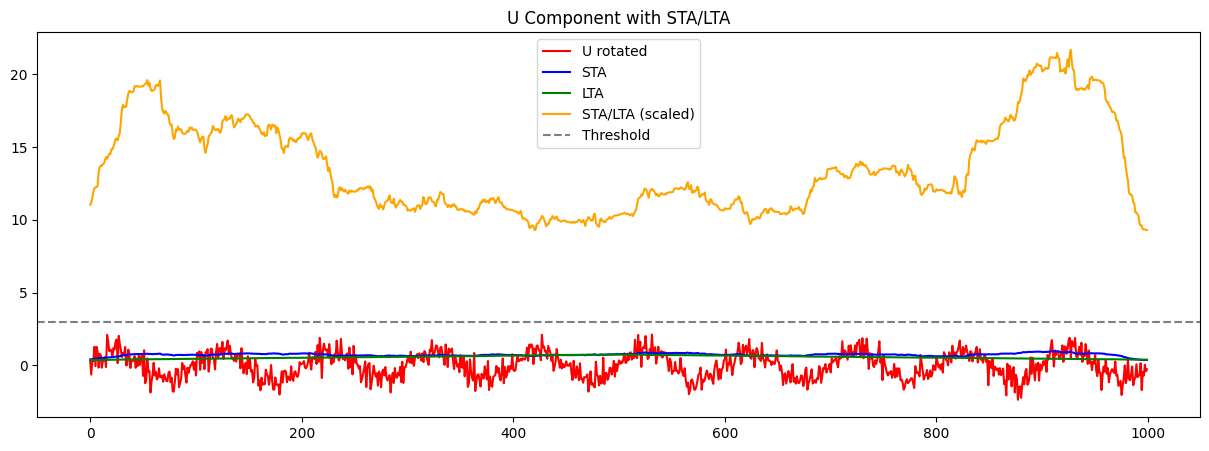

Detected quakes in V component at indices: []


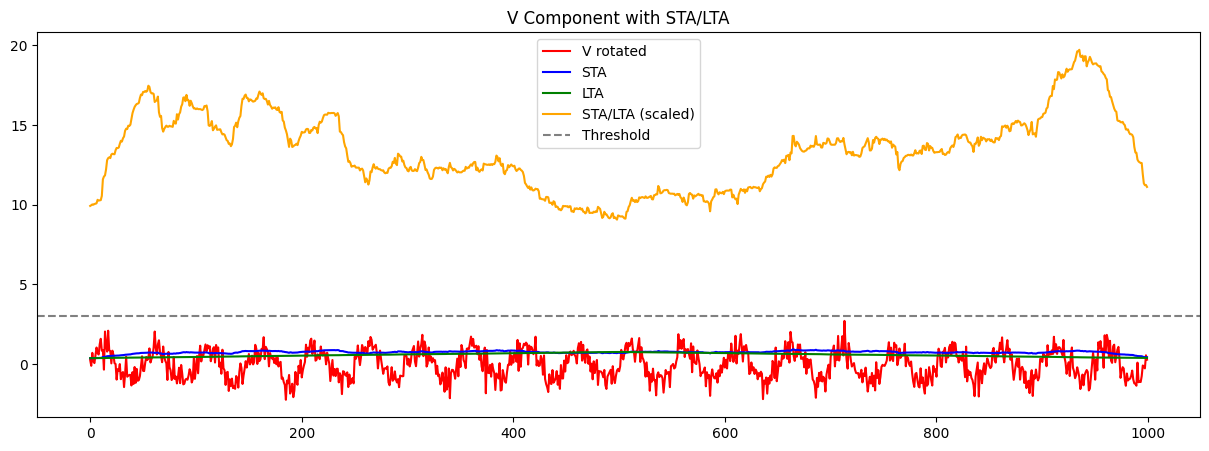

Detected quakes in W component at indices: []


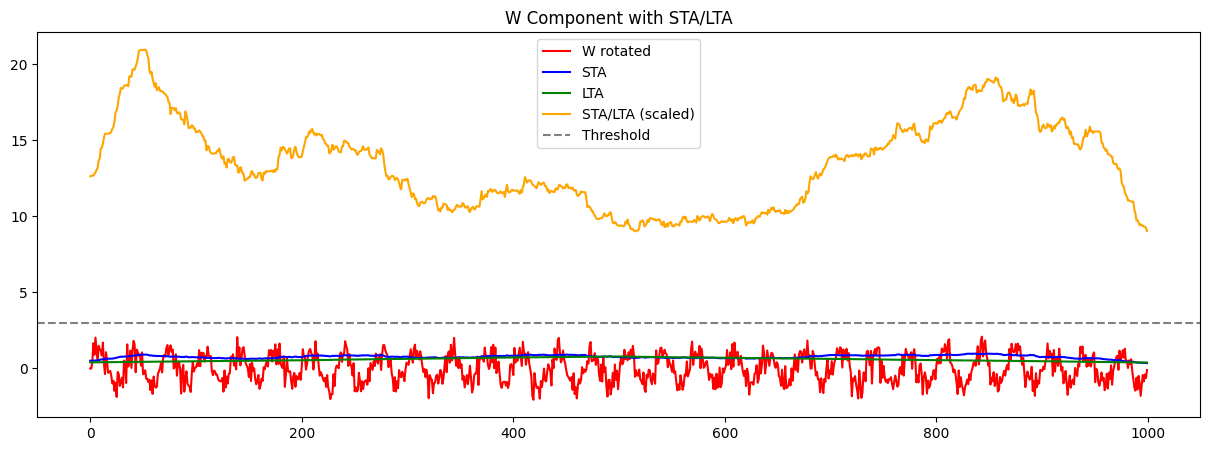

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sta_lta(signal, sta_length=100, lta_length=1000):
    """
    Calculate the STA/LTA for a given signal.

    Parameters:
    signal (array): Input signal
    sta_length (int): Length of the short-term average window
    lta_length (int): Length of the long-term average window

    Returns:
    tuple: STA, LTA, detection signal
    """
    sta = np.convolve(signal**2, np.ones(sta_length)/sta_length, mode='same')
    lta = np.convolve(signal**2, np.ones(lta_length)/lta_length, mode='same')
    return sta, lta

def detect_quakes(U_rotated, V_rotated, W_rotated, sta_length=100, lta_length=1000, threshold=3.0):
    """
    Detect possible quakes using the STA/LTA algorithm.

    Parameters:
    U_rotated, V_rotated, W_rotated (array): Rotated seismic components
    sta_length (int): Length of the short-term average window
    lta_length (int): Length of the long-term average window
    threshold (float): Detection threshold

    Returns:
    dict: Detected quake indices for each component
    """
    detected_quakes = {}

    for comp, name in zip([U_rotated, V_rotated, W_rotated], ['U', 'V', 'W']):
        sta, lta = sta_lta(comp, sta_length, lta_length)
        detection = sta / lta

        # Find indices where detection exceeds the threshold
        quake_indices = np.where(detection > threshold)[0]
        detected_quakes[name] = quake_indices

        # Print detected quake indices for each component
        print(f"Detected quakes in {name} component at indices: {quake_indices}")

        # Visualization of STA/LTA results for the component
        plt.figure(figsize=(15, 5))
        plt.plot(comp, label=f'{name} rotated', color='red')
        plt.plot(sta, label='STA', color='blue')
        plt.plot(lta, label='LTA', color='green')
        plt.plot(detection * 10, label='STA/LTA (scaled)', color='orange')  # Scale for visibility
        plt.axhline(y=threshold, color='gray', linestyle='--', label='Threshold')
        plt.title(f'{name} Component with STA/LTA')
        plt.legend()
        plt.show()

    return detected_quakes

detected_quakes = detect_quakes(U_rotated, V_rotated, W_rotated)